In [61]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [62]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [63]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [64]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [65]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview").sort_values("market_cap",ascending=False)
market.disconnect()

In [66]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [119]:
portfolios = PortfolioSelection.generate_possible_portfolios(ranking_metrics=["sma","sma_corr"],group_percentages=[0.5])
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "week" and portfolio.position_type.label == "long" and portfolio.selection_type.label == "top" and portfolio.allocation_type.label == "equal":
            filtered_portfolios.append(portfolio)
print(len(filtered_portfolios))

12


In [68]:
# additional_portfolios = []
# for portfolio in portfolios:
#     if portfolio.timeframe.value == "week" and portfolio.position_type.label == "long" and portfolio.selection_type.label != "long_short":
#         for member in Indicator:
#             pm = copy.deepcopy(portfolio)
#             pm.ranking_metric = member.label
#             additional_portfolios.append(pm)

In [96]:
rolling_window = 20
num_tickers = 3000
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=rolling_window)
            # price = Indicator.OPTIMAL.calculate(price,timeframe=rolling_window)
            price = Indicator.SMA.calculate(price,timeframe=rolling_window)
            price = Indicator.SMACorr.calculate(price,timeframe=rolling_window)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()
model_end = 2015
backtest_end = 2025
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4266/4266 [03:26<00:00, 20.71it/s]


In [84]:
simulation.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'adjclose', 'adjhigh',
       'adjlow', 'adjopen', 'adjvolume', 'divcash', 'splitfactor', 'ticker',
       'year', 'month', 'quarter', 'week', 'reference_price',
       'reference_volume', 'reference_high', 'reference_low', 'average_return',
       'standard_dev', 'rolling_dollar_volume', 'simple_moving_average',
       'drawdown', 'distance', 'sma', 'sma_corr', 'coefficient_of_variation'],
      dtype='object')

In [273]:
filtered_simulation = simulation[(simulation["adjclose"]<=10)].copy()

In [274]:
analysises = []
for portfolio in tqdm(filtered_portfolios):
    try:
        trades = portfolio.trades(filtered_simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        results["rolling_window"] = rolling_window
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.53s/it]


In [275]:
a = pd.DataFrame(analysises)

In [276]:
orivault.connect()
orivault.drop("results")
orivault.store("results",a.drop("portfolio",axis=1))
orivault.disconnect()

In [277]:
filtered_a = a.drop(["date","risk_type","timeframe","allocation_type","selection_percentage"],axis=1).sort_values("pnl",ascending=False)
top = filtered_a.head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,pnl,downside,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window
0,sma,long,STANDARD_DEV,top,1791.660014,0.500000,3.356965,533.714243,1.096366,0.912066,0.556909,1.014704,3.347138,<financial_common.portfolio_management.portfol...,20
10,sma_corr,long,DRAWDOWN,top,1480.683948,0.529412,2.746004,539.214122,1.086167,0.911401,0.545091,1.006664,2.736471,<financial_common.portfolio_management.portfol...,20
4,sma,long,DRAWDOWN,top,1340.945385,0.529412,2.680700,500.222010,1.086015,0.911823,0.545091,1.006774,2.670425,<financial_common.portfolio_management.portfol...,20
6,sma_corr,long,STANDARD_DEV,top,744.499401,0.500000,3.647313,204.122690,1.093617,0.912431,0.554727,1.012940,3.621619,<financial_common.portfolio_management.portfol...,20
11,sma_corr,long,DISTANCE,top,140.317089,0.500000,3.252658,43.139209,1.091887,0.912662,0.543818,1.010128,3.131082,<financial_common.portfolio_management.portfol...,20
2,sma,long,ROLLING_DOLLAR_VOLUME,top,121.453383,0.529412,2.122141,57.231531,1.085352,0.912638,0.534182,1.004899,2.030501,<financial_common.portfolio_management.portfol...,20
5,sma,long,DISTANCE,top,111.319363,0.500000,3.045253,36.555051,1.091277,0.912914,0.546182,1.010333,2.901779,<financial_common.portfolio_management.portfol...,20
8,sma_corr,long,ROLLING_DOLLAR_VOLUME,top,69.744189,0.529412,2.671396,26.107765,1.084681,0.912748,0.534000,1.004561,2.470510,<financial_common.portfolio_management.portfol...,20
7,sma_corr,long,AVERAGE_RETURN,top,14.266619,0.500000,1.716339,8.312240,1.076764,0.916631,0.543273,1.003627,1.085379,<financial_common.portfolio_management.portfol...,20
9,sma_corr,long,SIMPLE_MOVING_AVERAGE,top,13.319768,0.500000,2.499944,5.328026,1.089439,0.909346,0.527818,1.004402,1.535256,<financial_common.portfolio_management.portfol...,20


In [278]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

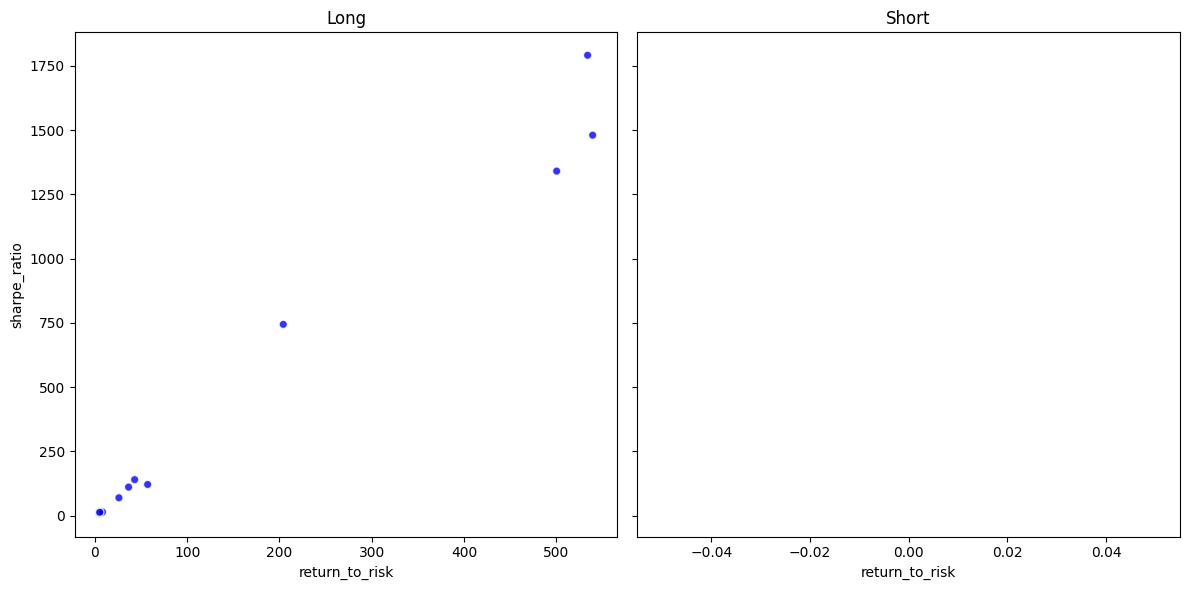

In [279]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [280]:
pm = top["portfolio"]
trades = pm.trades(filtered_simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

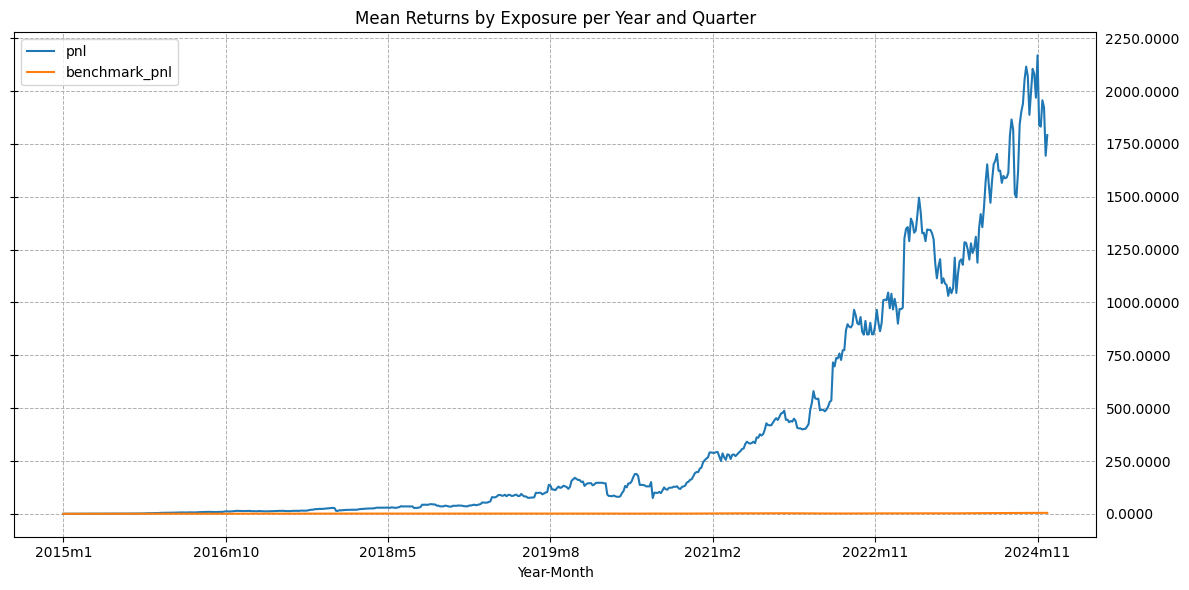

In [281]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio["month"].astype(str)
ax = portfolio[["Year-Month","pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [282]:
trades[["group_percentile","return"]].groupby("group_percentile").mean().sort_values("return",ascending=False)

,return
group_percentile,
0.9,1.024582
1.0,1.023119
0.7,1.021557
0.8,1.020131
0.5,1.019434
0.2,1.016721
0.1,1.016610
0.6,1.007529
0.3,1.007066


In [283]:
trades.sort_values("return",ascending=False).dropna().head(20)

,year,week,ticker,date,adjclose,sell_price,standard_dev,sma,risk,group_percentile,rank_percentile,position_type,weight,unweighted_return,winsorized_return,return,month,quarter
major_key,,,,,,,,,,,,,,,,,,
2024_9_0.1,2024,9,BSGM,2024-03-01 00:00:00+00:00,0.4790,0.7051,0.578144,2.128235,0.449296,0.1,0.007,1.0,1,1.335357,1.335357,1.335357,3,1
2016_31_1.0,2016,31,APCX,2016-08-05 00:00:00+00:00,0.0250,0.3000,0.028073,0.990000,0.244727,1.0,0.029,1.0,1,1.335357,1.335357,1.335357,8,3
2016_34_1.0,2016,34,APLD,2016-08-26 00:00:00+00:00,0.0615,0.1014,0.015916,0.296585,0.179910,1.0,0.029,1.0,1,1.335357,1.335357,1.335357,8,3
2016_38_0.1,2016,38,SNYR,2016-09-23 00:00:00+00:00,2.9750,4.1650,0.549411,0.675000,0.256001,0.1,0.015,1.0,1,1.335357,1.335357,1.335357,9,3
2016_21_0.2,2016,21,HUSA,2016-05-27 00:00:00+00:00,2.0200,3.1875,0.449915,0.355958,0.134811,0.2,0.014,1.0,1,1.335357,1.335357,1.335357,5,2
2016_40_0.7,2016,40,AMTX,2016-10-07 00:00:00+00:00,1.1700,1.6200,0.103951,0.187639,0.242896,0.7,0.015,1.0,1,1.335357,1.335357,1.335357,10,4
2016_40_1.0,2016,40,SCWO,2016-10-07 00:00:00+00:00,0.0800,0.1490,0.014790,0.365308,0.248244,1.0,0.029,1.0,1,1.335357,1.335357,1.335357,10,4
2016_41_1.0,2016,41,TSSI,2016-10-14 00:00:00+00:00,0.0720,0.1150,0.016337,0.243125,0.275003,1.0,0.029,1.0,1,1.335357,1.335357,1.335357,10,4
2024_43_0.8,2024,43,LRHC,2024-10-25 00:00:00+00:00,0.4850,0.8500,0.060920,0.186560,0.375642,0.8,0.006,1.0,1,1.335357,1.335357,1.335357,10,4


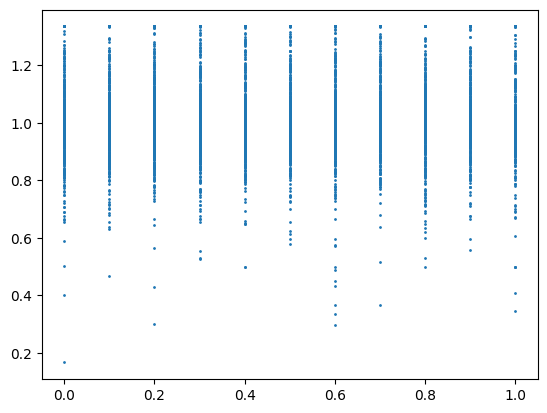

In [284]:
plt.scatter(trades["group_percentile"],trades["return"],s=1)
plt.show()